# Libraries import

In [1]:
# Import librairies
import jupyter_client
import pandas as pd
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import matplotlib.pyplot as plt
import os
os.environ['PROJ_LIB'] = '/home/roussillon/bin/miniconda3/envs/mon_env_py3/lib/python3.7/site-packages/mpl_toolkits/basemap'
#from eof import eof, seasonal_sig, interannual_sig, get_wgts, detrend
#from analysis import get_gen_chl, get_var, rmse_chl, nrmse_chl, print_map, cross_correlation
from mpl_toolkits.basemap import Basemap,cm 
import glob
from scipy.signal.windows import hann
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec
import os
import warnings
warnings.filterwarnings("ignore")
import xarray as xr
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from matplotlib.ticker import FormatStrFormatter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import cv2 as cv
import argparse
from torchvision import models, transforms
from carbontracker.tracker import CarbonTracker


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
print(torch.cuda.get_device_name(0))

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


Tesla T4
CUDA is available!  Training on GPU ...


# Data loading

In [2]:
class Interpolated_Img_Dataset(Dataset):
    
    def __init__(self, root_folder, input_file, output_file , transform=None, normalize=False):
        """
        Args:
            root_folder (String): path to input and output files
            input_file (String): npy file of the input data to be used by the NN
            output_file (String): npy file of the output data to be use by the NN
            transform (callable, Optional): Optional transform to be applied on
            a sample
        """
        self.root_folder = root_folder
        self.input_arr = np.load(os.path.join(self.root_folder, input_file ))
        self.output_arr = np.load(os.path.join(self.root_folder, output_file))
        self.transform = transform
        self.normalize = normalize
        self.mean_input = np.mean(self.input_arr, axis=(0,1,2))
        self.std_input = np.std(self.input_arr, axis=(0,1,2))
        self.mean_output = np.mean(self.output_arr)
        self.std_output = np.std(self.output_arr)        
        
    def __len__(self):
        return self.input_arr.shape[0]
    
    def __getitem__(self, idx):
        X = self.input_arr[idx,...]
        Y = self.output_arr[idx,...]
        
        if self.normalize:
            for ch in range(13):
                X[:,ch] = (X[:,ch] - self.mean_input[ch])/ self.std_input[ch]   ################### ch ??? 13 ??
            Y = (Y - self.mean_output)/ self.std_output
            
        if self.transform:
            X =  self.transform(X)
            Y =  self.transform(Y)
        
        return X,Y

In [3]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 2

# convert data to a torch.FloatTensor
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
img_path = './'

# Load input and reference data from .npy files :
train_data = Interpolated_Img_Dataset(img_path, 'normalized_input_physical_data_1998_2015.npy', 'ln_Chl_ref_norm_1998_2015.npy', transform=transform, normalize=False) 

# Load mean and std of normalized logarithm Chl reference data :
mean_Y = np.load('mean_ln_chl_norm.npy')
std_Y = np.load('std_ln_chl_norm.npy')

# Define train, validation and test datasets : 
train_idx, valid_idx_1, valid_idx_2 = [i for i in range(60,156)], [i for i in range(0,48)], [i for i in range(168,216)] 


train_sampler = SubsetRandomSampler(train_idx) 
valid_sampler_1 = SubsetRandomSampler(valid_idx_1)
valid_sampler_2 = SubsetRandomSampler(valid_idx_2)

# convert to data loaders :
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader_1 = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler_1, num_workers=num_workers)
valid_loader_2 = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler_2, num_workers=num_workers)



# Definition of the model architecture and hyperparameters

In [5]:
# Definition of the 8 sub-models : 

class CNN_M1(nn.Module):
    def __init__(self):
        super(CNN_M1, self).__init__()
        self.conv1 = nn.Conv2d(9,16,3, padding =(1,1))    
        self.conv2 = nn.Conv2d(16,32,3, padding =(1,1))
        self.conv3 = nn.Conv2d(32,64,3, padding =(1,1))
        self.conv4 = nn.Conv2d(64,128,3, padding =(1,1))
        self.conv5 = nn.Conv2d(128,1,3, padding =(1,1))
        self.dropout = nn.Dropout(0.35)
        
    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = self.conv5(x)
        return x
    

class CNN_M2(nn.Module):
    def __init__(self):
        super(CNN_M2, self).__init__()
        self.conv1 = nn.Conv2d(9,16,3, padding =(1,1))    
        self.conv2 = nn.Conv2d(16,32,3, padding =(1,1))
        self.conv3 = nn.Conv2d(32,64,3, padding =(1,1))
        self.conv4 = nn.Conv2d(64,128,3, padding =(1,1))
        self.conv5 = nn.Conv2d(128,1,3, padding =(1,1))
        self.dropout = nn.Dropout(0.35)
        
    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = self.conv5(x)
        return x
    
class CNN_M3(nn.Module):
    def __init__(self):
        super(CNN_M3, self).__init__()
        self.conv1 = nn.Conv2d(9,16,3, padding =(1,1))    
        self.conv2 = nn.Conv2d(16,32,3, padding =(1,1))
        self.conv3 = nn.Conv2d(32,64,3, padding =(1,1))
        self.conv4 = nn.Conv2d(64,128,3, padding =(1,1))
        self.conv5 = nn.Conv2d(128,1,3, padding =(1,1))
        self.dropout = nn.Dropout(0.35)
        
    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = self.conv5(x)
        return x
    
class CNN_M4(nn.Module):
    def __init__(self):
        super(CNN_M4, self).__init__()
        self.conv1 = nn.Conv2d(9,16,3, padding =(1,1))    
        self.conv2 = nn.Conv2d(16,32,3, padding =(1,1))
        self.conv3 = nn.Conv2d(32,64,3, padding =(1,1))
        self.conv4 = nn.Conv2d(64,128,3, padding =(1,1))
        self.conv5 = nn.Conv2d(128,1,3, padding =(1,1))
        self.dropout = nn.Dropout(0.35)
        
    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = self.conv5(x)
        return x
    
class CNN_M5(nn.Module):
    def __init__(self):
        super(CNN_M5, self).__init__()
        self.conv1 = nn.Conv2d(9,16,3, padding =(1,1))    
        self.conv2 = nn.Conv2d(16,32,3, padding =(1,1))
        self.conv3 = nn.Conv2d(32,64,3, padding =(1,1))
        self.conv4 = nn.Conv2d(64,128,3, padding =(1,1))
        self.conv5 = nn.Conv2d(128,1,3, padding =(1,1))
        self.dropout = nn.Dropout(0.35)
        
    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = self.conv5(x)
        return x
    
class CNN_M6(nn.Module):
    def __init__(self):
        super(CNN_M6, self).__init__()
        self.conv1 = nn.Conv2d(9,16,3, padding =(1,1))    
        self.conv2 = nn.Conv2d(16,32,3, padding =(1,1))
        self.conv3 = nn.Conv2d(32,64,3, padding =(1,1))
        self.conv4 = nn.Conv2d(64,128,3, padding =(1,1))
        self.conv5 = nn.Conv2d(128,1,3, padding =(1,1))
        self.dropout = nn.Dropout(0.35)
        
    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = self.conv5(x)
        return x
    
class CNN_M7(nn.Module):
    def __init__(self):
        super(CNN_M7, self).__init__()
        self.conv1 = nn.Conv2d(9,16,3, padding =(1,1))    
        self.conv2 = nn.Conv2d(16,32,3, padding =(1,1))
        self.conv3 = nn.Conv2d(32,64,3, padding =(1,1))
        self.conv4 = nn.Conv2d(64,128,3, padding =(1,1))
        self.conv5 = nn.Conv2d(128,1,3, padding =(1,1))
        self.dropout = nn.Dropout(0.35)
        
    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = self.conv5(x)
        return x
    
class CNN_M8(nn.Module):
    def __init__(self):
        super(CNN_M8, self).__init__()
        self.conv1 = nn.Conv2d(9,16,3, padding =(1,1))    
        self.conv2 = nn.Conv2d(16,32,3, padding =(1,1))
        self.conv3 = nn.Conv2d(32,64,3, padding =(1,1))
        self.conv4 = nn.Conv2d(64,128,3, padding =(1,1))
        self.conv5 = nn.Conv2d(128,1,3, padding =(1,1))
        self.dropout = nn.Dropout(0.35)
        
    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = self.conv5(x)
        return x
    
# Definition of the W attention module :
    
class CNN_W(nn.Module):
    def __init__(self):
        super(CNN_W, self).__init__()
        self.conv1 = nn.Conv2d(9,16,3, padding =(1,1))    
        self.conv2 = nn.Conv2d(16,32,3, padding =(1,1))
        self.conv3 = nn.Conv2d(32,8,3, padding =(1,1))
        self.dropout = nn.Dropout(0.35)

        
    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = (F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = (F.softmax(self.conv3(x)))
        return x

    
model_M1 = CNN_M1()
model_M2 = CNN_M2()
model_M3 = CNN_M3()
model_M4 = CNN_M4()
model_M5 = CNN_M5()
model_M6 = CNN_M6()
model_M7 = CNN_M7()
model_M8 = CNN_M8()
model_W = CNN_W()

# move tensors to GPU if CUDA is available
model_M1.to(torch.device('cuda:0'))         
model_M1 = model_M1.double()
             
model_M2.to(torch.device('cuda:0'))         
model_M2 = model_M2.double()

model_M3.to(torch.device('cuda:0'))         
model_M3 = model_M3.double()

model_M4.to(torch.device('cuda:0'))         
model_M4 = model_M4.double()

model_M5.to(torch.device('cuda:0'))         
model_M5 = model_M5.double()

model_M6.to(torch.device('cuda:0'))         
model_M6 = model_M6.double()

model_M7.to(torch.device('cuda:0'))         
model_M7 = model_M7.double()

model_M8.to(torch.device('cuda:0'))         
model_M8 = model_M8.double()
             
model_W.to(torch.device('cuda:0'))         
model_W = model_W.double()

# specify loss function 
criterion = torch.nn.MSELoss()

# specify optimizer
optimizer_1 = optim.Adam(model_M1.parameters(), lr=0.001)
optimizer_2 = optim.Adam(model_M2.parameters(), lr=0.001)
optimizer_3 = optim.Adam(model_M3.parameters(), lr=0.001)
optimizer_4 = optim.Adam(model_M4.parameters(), lr=0.001)
optimizer_5 = optim.Adam(model_M5.parameters(), lr=0.001)
optimizer_6 = optim.Adam(model_M6.parameters(), lr=0.001)
optimizer_7 = optim.Adam(model_M7.parameters(), lr=0.001)
optimizer_8 = optim.Adam(model_M8.parameters(), lr=0.001)
optimizer_W = optim.Adam(model_W.parameters(), lr=0.001)


print('Definition of 8 sub-models Mi with the architecture :') 
print(model_M1)
print('and one attention module W that outputs 8 weighted maps :')
print(model_W)


Definition of 8 sub-models Mi with the architecture :
CNN_M1(
  (conv1): Conv2d(9, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.35, inplace=False)
)
and one attention module W that outputs 8 weighted maps :
CNN_W(
  (conv1): Conv2d(9, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.35, inplace=False)
)


---
---

# Training

CarbonTracker: The following components were found: GPU with device(s) Tesla T4. CPU with device(s) .
Epoch: 1/5 	Training Loss: 0.232770 	Validation Loss 1: 0.151104 	Validation Loss 2: 0.205393
CarbonTracker: Live carbon intensity could not be fetched at detected location: Brest, Brittany, FR. Defaulted to average carbon intensity for EU-28 in 2017 of 294.21 gCO2/kWh.
CarbonTracker: 
Predicted consumption for 6 epoch(s):
	Time:	0:28:14
	Energy:	0.041784 kWh
	CO2eq:	12.293000 g
	This is equivalent to:
	0.102101 km travelled by car
Epoch: 2/5 	Training Loss: 0.151635 	Validation Loss 1: 0.127553 	Validation Loss 2: 0.178409
Epoch: 3/5 	Training Loss: 0.128931 	Validation Loss 1: 0.110687 	Validation Loss 2: 0.173397
Epoch: 4/5 	Training Loss: 0.119371 	Validation Loss 1: 0.103005 	Validation Loss 2: 0.163804
Epoch: 5/5 	Training Loss: 0.107748 	Validation Loss 1: 0.099748 	Validation Loss 2: 0.156609
CarbonTracker: Average carbon intensity during training was 294.21 gCO2/kWh at detecte

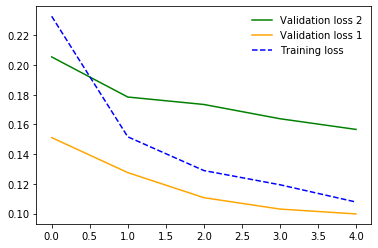

In [6]:
#############################################
######### Weighted neural network  ##########  #### 8 modes
#############################################

model_1 = model_M1   
model_2 = model_M2  
model_3 = model_M3  
model_4 = model_M4 
model_5 = model_M5 
model_6 = model_M6 
model_7 = model_M7 
model_8 = model_M8 
model_W = model_W 


## Specify number of epochs : 
n_epochs = 500

## Specify a folder name in which the trained odels will be saved, as well as their root name :
folder_name = './FOLDER_TO_SAVE_TRAINED_MODELS/'
model_name = 'root_names_of_trained_modeds'

folder_name2 = folder_name + model_name + '/'
model_save_1 = folder_name + model_name + '_1.pt'
model_save_2 = folder_name + model_name + '_2.pt'
model_save_3 = folder_name + model_name + '_3.pt'
model_save_4 = folder_name + model_name + '_4.pt'
model_save_5 = folder_name + model_name + '_5.pt'
model_save_6 = folder_name + model_name + '_6.pt'
model_save_7 = folder_name + model_name + '_7.pt'
model_save_8 = folder_name + model_name + '_8.pt'
model_save_W = folder_name + model_name + '_W.pt'



#######################
# Monitoring metrics during training loop :
loss_mask = 0
corr_epoque_affichage = 10
scatter_epoque_affichage = 50
loss_fig = 10
loss_fig_epoque_affichage = 10
write_file_epoque = 10
scatter_corr = 1

#######################
# Training loop :
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Import continental mask to compute the loss only on the ocean (not on the land)
mask = torch.load('inter_mask.pt')
mask = mask.bool()
mask = mask.reshape([1,1,178,358])
mask.to(device)

# Monitoring carbon footprint
import time
from carbontracker.tracker import CarbonTracker
from carbontracker import parser

# Check for time computation
tps_ini = time.clock()


torch.set_default_dtype(torch.float64)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create output folder to save the data
if not os.path.exists(folder_name2):
 os.makedirs(folder_name2)

tracker = CarbonTracker(epochs=n_epochs+1, verbose = 2, log_dir = folder_name2, monitor_epochs = n_epochs)

# Initialisation of the loss value
train_losses_save, test_losses_save_1, test_losses_save_2 = [], [], [] 

valid_loss_min_1 = np.Inf # track change in validation loss
valid_loss_min_2 = np.Inf # track change in validation loss

scheduler1 = torch.optim.lr_scheduler.MultiStepLR(optimizer_1, milestones=[400], gamma=0.1)
scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer_2, milestones=[400], gamma=0.1)
scheduler3 = torch.optim.lr_scheduler.MultiStepLR(optimizer_3, milestones=[400], gamma=0.1)
scheduler4 = torch.optim.lr_scheduler.MultiStepLR(optimizer_4, milestones=[400], gamma=0.1)
scheduler5 = torch.optim.lr_scheduler.MultiStepLR(optimizer_5, milestones=[400], gamma=0.1)
scheduler6 = torch.optim.lr_scheduler.MultiStepLR(optimizer_6, milestones=[400], gamma=0.1)
scheduler7 = torch.optim.lr_scheduler.MultiStepLR(optimizer_7, milestones=[400], gamma=0.1)
scheduler8 = torch.optim.lr_scheduler.MultiStepLR(optimizer_8, milestones=[400], gamma=0.1)
schedulerW = torch.optim.lr_scheduler.MultiStepLR(optimizer_W, milestones=[400], gamma=0.1)

from carbontracker import parser   
for epoch in range(1, n_epochs+1):
    
    tracker.epoch_start()
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss_1 = 0.0
    valid_loss_2 = 0.0
    
    compteur = 0
        
    ###################
    # train the model #
    ###################
        
    model_1.train()
    model_2.train()
    model_3.train()
    model_4.train()
    model_5.train()
    model_6.train()
    model_7.train()
    model_8.train()
    model_W.train()
        
    for data, target in train_loader:

        data,target=data.to(device,dtype=torch.float64),target.to(device,dtype=torch.float64)
        # clear the gradients of all optimized variables
        optimizer_1.zero_grad()
        optimizer_2.zero_grad()
        optimizer_3.zero_grad()
        optimizer_4.zero_grad()
        optimizer_5.zero_grad()
        optimizer_6.zero_grad()
        optimizer_7.zero_grad()
        optimizer_8.zero_grad()
        optimizer_W.zero_grad()
            
        ################################################################
        # Calculation of the final output as a combination of the 8 sub-models
        ################################################################
            
        output_W = model_W(data.double()) 
        output_1 = model_1(data.double()) 
        output_2 = model_2(data.double()) 
        output_3 = model_3(data.double()) 
        output_4 = model_4(data.double()) 
        output_5 = model_5(data.double()) 
        output_6 = model_6(data.double()) 
        output_7 = model_7(data.double()) 
        output_8 = model_8(data.double()) 
            
        # Weighted average
        
        W1 = output_W[:,0,:,:]
        W1 = torch.reshape(W1, (batch_size, 1,178, 358))
        
        W2 = output_W[:,1,:,:]
        W2 = torch.reshape(W2, (batch_size, 1,178, 358))
        
        W3 = output_W[:,2,:,:]
        W3 = torch.reshape(W3, (batch_size, 1,178, 358))
        
        W4 = output_W[:,3,:,:]
        W4 = torch.reshape(W4, (batch_size, 1,178, 358))
        
        W5 = output_W[:,4,:,:]
        W5 = torch.reshape(W5, (batch_size, 1,178, 358))
        
        W6 = output_W[:,5,:,:]
        W6 = torch.reshape(W6, (batch_size, 1,178, 358))
        
        W7 = output_W[:,6,:,:]
        W7 = torch.reshape(W7, (batch_size, 1,178, 358))
        
        W8 = output_W[:,7,:,:]
        W8 = torch.reshape(W8, (batch_size, 1,178, 358))
        
        output_1 = torch.mul(output_1, W1)
        output_2 = torch.mul(output_2, W2)
        output_3 = torch.mul(output_3, W3)
        output_4 = torch.mul(output_4, W4)
        output_5 = torch.mul(output_5, W5)
        output_6 = torch.mul(output_6, W6)
        output_7 = torch.mul(output_7, W7)
        output_8 = torch.mul(output_8, W8)
            
        # Concatenation
        concat = torch.cat((output_1, output_2, output_3, output_4, output_5, output_6, output_7, output_8), 1) 
            
        # Sum on the last dimension
        output = torch.sum(concat, 1)
        output = torch.reshape(output, (batch_size, 1,178, 358)) # Reshape to apply the continental mask
            
        ######################################################
        # Loss computation
        ######################################################
        
        compteur = compteur + 1
        
        output2 = output
        target2 = target
        
        where_are_NaNs = np.isnan(target.cpu())
        
        ######################
        ########################################################### 
        #  Training only on 50N / 50S
        
        where_are_NaNs[:,0,0:39,:] = 1
        where_are_NaNs[:,0,139:178,:] = 1
        
        ########################################################### 
        ######################
        
        
        where_are_NaNs = where_are_NaNs.bool()
        where_are_NaNs = ~where_are_NaNs
        where_are_NaNs = where_are_NaNs.to(device)
        
        output2 = torch.masked_select(output2, where_are_NaNs)
        target2 = torch.masked_select(target2, where_are_NaNs)
                 
        # calculate the batch loss
        loss = criterion(output2.double(), target2.double())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer_1.step()
        optimizer_2.step()
        optimizer_3.step()
        optimizer_4.step()
        optimizer_5.step()
        optimizer_6.step()
        optimizer_7.step()
        optimizer_8.step()
        optimizer_W.step()
        
        # update training loss
        train_loss += loss.item()
           
    scheduler1.step()
    scheduler2.step()
    scheduler3.step()
    scheduler4.step()
    scheduler5.step()
    scheduler6.step()
    scheduler7.step()
    scheduler8.step()
    schedulerW.step()
    
    model_1.eval()
    model_2.eval()
    model_3.eval()
    model_4.eval()
    model_5.eval()
    model_6.eval()
    model_7.eval()
    model_8.eval()
    model_W.eval()
    
    for data, target in valid_loader_1:

        data,target=data.to(device,dtype=torch.float),target.to(device,dtype=torch.float)
            
        output_W = model_W(data.double()) 
        output_1 = model_1(data.double()) 
        output_2 = model_2(data.double()) 
        output_3 = model_3(data.double()) 
        output_4 = model_4(data.double())
        output_5 = model_5(data.double()) 
        output_6 = model_6(data.double()) 
        output_7 = model_7(data.double())
        output_8 = model_8(data.double())
            
        
        W1 = output_W[:,0,:,:]
        W1 = torch.reshape(W1, (batch_size, 1,178, 358))
        
        W2 = output_W[:,1,:,:]
        W2 = torch.reshape(W2, (batch_size, 1,178, 358))
        
        W3 = output_W[:,2,:,:]
        W3 = torch.reshape(W3, (batch_size, 1,178, 358))
        
        W4 = output_W[:,3,:,:]
        W4 = torch.reshape(W4, (batch_size, 1,178, 358))
        
        W5 = output_W[:,4,:,:]
        W5 = torch.reshape(W5, (batch_size, 1,178, 358))
        
        W6 = output_W[:,5,:,:]
        W6 = torch.reshape(W6, (batch_size, 1,178, 358))
        
        W7 = output_W[:,6,:,:]
        W7 = torch.reshape(W7, (batch_size, 1,178, 358))
        
        W8 = output_W[:,7,:,:]
        W8 = torch.reshape(W8, (batch_size, 1,178, 358))
        
        output_1 = torch.mul(output_1, W1)
        output_2 = torch.mul(output_2, W2)
        output_3 = torch.mul(output_3, W3)
        output_4 = torch.mul(output_4, W4)
        output_5 = torch.mul(output_5, W5)
        output_6 = torch.mul(output_6, W6)
        output_7 = torch.mul(output_7, W7)
        output_8 = torch.mul(output_8, W8)

        concat = torch.cat((output_1, output_2, output_3, output_4, output_5, output_6, output_7, output_8), 1)   
            
        output = torch.sum(concat, 1)
        output = torch.reshape(output, (batch_size, 1,178, 358)) 
       
          
        output2 = output
        target2 = target
        
        where_are_NaNs = np.isnan(target.cpu())

        
        where_are_NaNs[:,0,0:39,:] = 1
        where_are_NaNs[:,0,139:178,:] = 1
        
        
        where_are_NaNs = where_are_NaNs.bool()
        where_are_NaNs = ~where_are_NaNs
        where_are_NaNs = where_are_NaNs.to(device)
        
        output2 = torch.masked_select(output2, where_are_NaNs)
        target2 = torch.masked_select(target2, where_are_NaNs)
        

            # calculate the batch loss
        loss = criterion(output2.double(), target2.double())
            # update average validation loss 
        valid_loss_1 += loss.item()
        
    
    ######################    
    # validate the model 2 #
    ######################
    
    model_1.eval()
    model_2.eval()
    model_3.eval()
    model_4.eval()
    model_5.eval()
    model_6.eval()
    model_7.eval()
    model_8.eval()
    model_W.eval()
    
    for data, target in valid_loader_2:

        data,target=data.to(device,dtype=torch.float),target.to(device,dtype=torch.float)
            
        ################################################################
        # Calculation of the final output as a combination of the 8 sub-models
        ################################################################
            
        output_W = model_W(data.double())
        output_1 = model_1(data.double()) 
        output_2 = model_2(data.double())
        output_3 = model_3(data.double()) 
        output_4 = model_4(data.double()) 
        output_5 = model_5(data.double()) 
        output_6 = model_6(data.double()) 
        output_7 = model_7(data.double())
        output_8 = model_8(data.double()) 
            
        # Weighted average
        
        W1 = output_W[:,0,:,:]
        W1 = torch.reshape(W1, (batch_size, 1,178, 358))
        
        W2 = output_W[:,1,:,:]
        W2 = torch.reshape(W2, (batch_size, 1,178, 358))
        
        W3 = output_W[:,2,:,:]
        W3 = torch.reshape(W3, (batch_size, 1,178, 358))
        
        W4 = output_W[:,3,:,:]
        W4 = torch.reshape(W4, (batch_size, 1,178, 358))
        
        W5 = output_W[:,4,:,:]
        W5 = torch.reshape(W5, (batch_size, 1,178, 358))
        
        W6 = output_W[:,5,:,:]
        W6 = torch.reshape(W6, (batch_size, 1,178, 358))
        
        W7 = output_W[:,6,:,:]
        W7 = torch.reshape(W7, (batch_size, 1,178, 358))
        
        W8 = output_W[:,7,:,:]
        W8 = torch.reshape(W8, (batch_size, 1,178, 358))
        
        output_1 = torch.mul(output_1, W1)
        output_2 = torch.mul(output_2, W2)
        output_3 = torch.mul(output_3, W3)
        output_4 = torch.mul(output_4, W4)
        output_5 = torch.mul(output_5, W5)
        output_6 = torch.mul(output_6, W6)
        output_7 = torch.mul(output_7, W7)
        output_8 = torch.mul(output_8, W8)
            
        # Concatenation
        concat = torch.cat((output_1, output_2, output_3, output_4, output_5, output_6, output_7, output_8), 1)  
            
        # Sum on the last dimension
        output = torch.reshape(output, (batch_size, 1,178, 358)) 
       
        #########################       
  
        output2 = output
        target2 = target
        
        where_are_NaNs = np.isnan(target.cpu())

        ######################
        ########################################################### 
        #  Compute the loss only on 50N / 50S
        
        where_are_NaNs[:,0,0:39,:] = 1
        where_are_NaNs[:,0,139:178,:] = 1
        
        ########################################################### 
        ######################
       
        where_are_NaNs = where_are_NaNs.bool()
        where_are_NaNs = ~where_are_NaNs
        where_are_NaNs = where_are_NaNs.to(device)
        
        output2 = torch.masked_select(output2, where_are_NaNs) 
        target2 = torch.masked_select(target2, where_are_NaNs)

            # calculate the batch loss
        loss = criterion(output2.double(), target2.double())
            # update average validation loss 
        valid_loss_2 += loss.item()

        # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss_1 = valid_loss_1/len(valid_loader_1.sampler)
    valid_loss_2 = valid_loss_2/len(valid_loader_2.sampler)
    
    train_losses_save.append(train_loss)
    test_losses_save_1.append(valid_loss_1)
    test_losses_save_2.append(valid_loss_2)
    
    # Save the loss in files
    np.save(folder_name2 + 'train_losses_save.npy',train_losses_save)
    np.save(folder_name2 + 'test_losses_save_1.npy',test_losses_save_1)
    np.save(folder_name2 + 'test_losses_save_2.npy',test_losses_save_2)
    
    # print loss/training curves to monitor overfitting / convergence
    if loss_fig ==1 and epoch%loss_fig_epoque_affichage ==0 :
        fig1=plt.figure(figsize=(3,3))
        plt.plot(test_losses_save_2, label='Validation loss 2',color='green')
        plt.plot(test_losses_save_1, label='Validation loss 1',color='orange')
        plt.plot(train_losses_save, label='Training loss',color='blue', linestyle='dashed')
        plt.legend(frameon=False)
        plt.show()
        
        # print training/validation statistics 
    print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss 1: {:.6f} \tValidation Loss 2: {:.6f}'.format(epoch, n_epochs, train_loss, valid_loss_1, valid_loss_2))
    if scatter_corr == 1 and epoch%corr_epoque_affichage ==0 :
        print('Epoch: {}/{} \t Corr coeff 1: {}, RMSE 1: {}      ///         Corr coeff 2: {}, RMSE 2: {}'.format(epoch, n_epochs, round(corcoef1,2), round(rmse1,2),round(corcoef2,2), round(rmse2,2)))

        tps_t = time.clock()
        print('Temps écoulé : {} min'.format(round((tps_t - tps_ini)/60),2))
        
    
    # save model if validation loss has decreased
    if valid_loss_1 <= valid_loss_min_1:
        torch.save(model_1.state_dict(), model_save_1 )   
        torch.save(model_2.state_dict(), model_save_2 ) 
        torch.save(model_3.state_dict(), model_save_3 ) 
        torch.save(model_4.state_dict(), model_save_4 ) 
        torch.save(model_5.state_dict(), model_save_5 ) 
        torch.save(model_6.state_dict(), model_save_6 ) 
        torch.save(model_7.state_dict(), model_save_7 ) 
        torch.save(model_8.state_dict(), model_save_8 ) 
        torch.save(model_W.state_dict(), model_save_W ) 
        
        valid_loss_min_1 = valid_loss_1
        
    tracker.epoch_end()
tracker.stop()


tps_final = time.clock()
tps_final_min = round((tps_final - tps_ini)/60,2)
print('Time computation : {} min'.format(tps_final_min))

    ########################################################################
    ### Check overfitting / save loss
    ########################################################################


plt.plot(test_losses_save_2, label='Validation loss 2',color='green')
plt.plot(test_losses_save_1, label='Validation loss 1',color='orange')
plt.plot(train_losses_save, label='Training loss',color='blue', linestyle='dashed')

plt.legend(frameon=False)
plt.savefig(folder_name2 + 'Loss', dpi= 100,bbox_inches = "tight")

plt.show()





